In [1]:
# Import stuff
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm

from jaxtyping import Float
from functools import partial

# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

import torch
torch.set_grad_enabled(False)

In [2]:
import torch ,os
from utils import data_loader, misc, n_grams
from collections import defaultdict

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

torch.set_grad_enabled(False)
misc.seed_everything(555)

In [3]:
# load model and tokenizer
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained("Qwen/Qwen2.5-3B")
num_layers = model.cfg.n_layers
# tokenizer = Qwen2Tokenizer.from_pretrained("Qwen/Qwen2.5-3B")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen2.5-3B into HookedTransformer


In [4]:
_, _, edited_phrases = data_loader.wiki_loader(num_samples=2000000)

In [5]:
schemas = {
    # 'swap_is_are': data_loader.Scheme(source= 'is',
    #                                      target= 'are').swap_words,
    # 'swap_was_were': data_loader.Scheme(source= 'was',
    #                                      target= 'were').swap_words,
    # 'swap_a_the': data_loader.Scheme(source= 'a',
    #                                      target= 'the').swap_words,
    # 'drop_a': data_loader.Scheme(source= 'a',
    #                                      target= '').drop_words,
    'char_edit': data_loader.Scheme().char_edit,
}

# Plot on Turning Points

In [23]:
from utils.misc import get_top_k, get_acc
from utils.n_grams import detect_ngram_copy

def ngram_char_edits(model, skip_up_to, edited_phrases, schema, n=5, k=100):
    # print("n-gram: ", n)
    # print("Skip layers: ", skip_up_to)

    return_scores = [] 
    total_patched_words = 20
    total_solvable_dict = {
        'swap': 0,
        'drop': 0,
        'add': 0
    }

    for edited in edited_phrases:
        if total_solvable_dict['swap'] == 3 and \
            total_solvable_dict['drop'] == 3 and \
                total_solvable_dict['add'] == 4:
            break
        
        return_outputs = schema(text = edited, model = model)
        if not return_outputs:
            continue

        # preprocess text
        for method, outputs in return_outputs.items():
            if total_solvable_dict[method] == 3 and method in ['swap', 'drop']:
                continue
            if total_solvable_dict[method] == 4 and method in ['add']:
                continue
            corrupted_sentence, decoded_up_to, ground_truth_next = outputs
            prompt = f"Please fix grammar of the following text: '{corrupted_sentence}'. The correct text is: {decoded_up_to}"
            prompt_tokens = model.to_tokens(prompt, prepend_bos=False)

            # run on the prompt once with cache to store activations to patch in later
            og_logits, og_cache = model.run_with_cache(prompt_tokens)
            # get the top k tokens
            og_topk_indices = get_top_k(og_logits, k)
            # get the highest prob token
            og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

            # check if model can solve the task
            decoded_og_next_token = model.to_string(og_next_token)[0]
            if ground_truth_next in decoded_og_next_token: 
                total_solvable_dict[method] += 1
            else:
                # total_unsolvable += 1
                continue

            patching_succeed_flag = True
            score_list_dict = {
                'acc2': [],
                'acc3': [],
                'jcc': []
            }       
            # start on patching model
            for num_word2patch in range(1, total_patched_words+1):
                if not patching_succeed_flag:
                    break

                dict_pred_info = defaultdict(dict)

                pos_matched = []
                pos_current = []
                total_matches = []

                for id in range(num_word2patch):
                    assert id < len(prompt_tokens[0])
                    pos_matched.append(detect_ngram_copy(prompt_tokens[:, :len(prompt_tokens[0])-id], n=n)[0])
                    pos_current.append(len(prompt_tokens[0])-id-1)

                # if there any none of finding ngram, break the experiment with current prompt
                # as it does not have enough tokens
                if None in pos_matched:
                    total_solvable_dict[method] -= 1
                    patching_succeed_flag = False
                    break            
                    
                # start hooking
                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    pos_matched: list,
                    pos_current: list
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, pos_current, :] = clean_resid_pre[:, pos_matched, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, pos_matched=pos_matched, pos_current=pos_current)
                # Run the model with the patching hook
                patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                    (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                ])
            
                pt_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                pt_next_token = torch.tensor([pt_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                # compare the predicted to the og prediction
                if torch.equal(og_next_token, pt_next_token):
                    total_matches.append(1)
                else:
                    total_matches.append(0)

                dict_pred_info[0]['original'] = og_topk_indices
                dict_pred_info[0]['copy'] = get_top_k(patched_logits, k)
            
                jcc, acc = get_acc([dict_pred_info])
                score_list_dict["acc2"].append(acc)
                score_list_dict["jcc"].append(jcc)
                score_list_dict["acc3"].append(sum(total_matches) / len(total_matches))

            if patching_succeed_flag:
                return_scores.append(score_list_dict)
    
    return return_scores

In [24]:
from tqdm import tqdm
task_name = 'turning_points'
info_lst = defaultdict(list)
for schema_name, schema in schemas.items():
    print(schema_name)
    for skip in tqdm(range(num_layers-1)):
        skip += 1
        if schema_name == 'char_edit':
            outputs = ngram_char_edits(model= model,
                                            skip_up_to= skip,
                                            edited_phrases= edited_phrases,
                                            schema= schema)
        else:
            outputs = n_grams.ngram(model= model,
                            skip_up_to= skip,
                            edited_phrases= edited_phrases,
                            schema= schema)
        info_lst[schema_name].append(outputs)

    misc.save_dict_to_json(info_lst[schema_name], f"output/{task_name}_{schema_name}.json")

char_edit


  3%|▎         | 1/35 [00:15<08:57, 15.80s/it]


KeyboardInterrupt: 

In [8]:
len(info_lst['swap is/are'][0])

71

In [7]:
len(loaded_data[0])

100

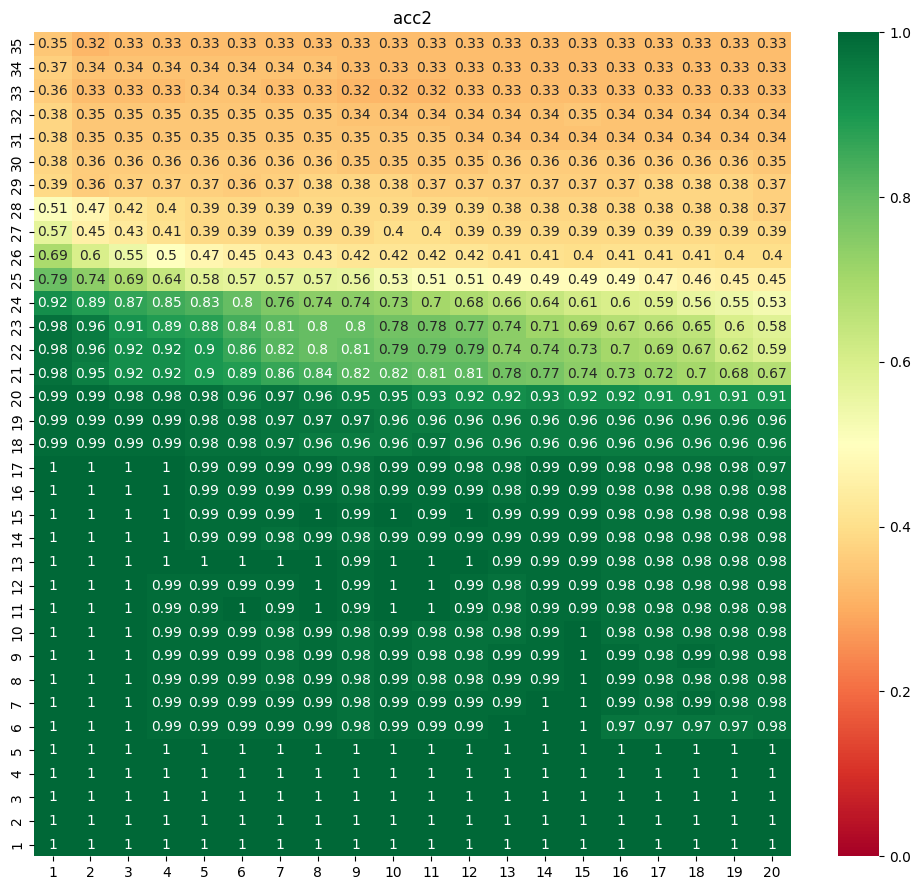

In [1]:
from utils import misc
task_name = 'turning_points'
loaded_data = misc.load_dict_from_json(f"output/copy_mode_swap_a_the.json")
misc.plot_score_heatmaps(loaded_data, score_types=['acc2'])

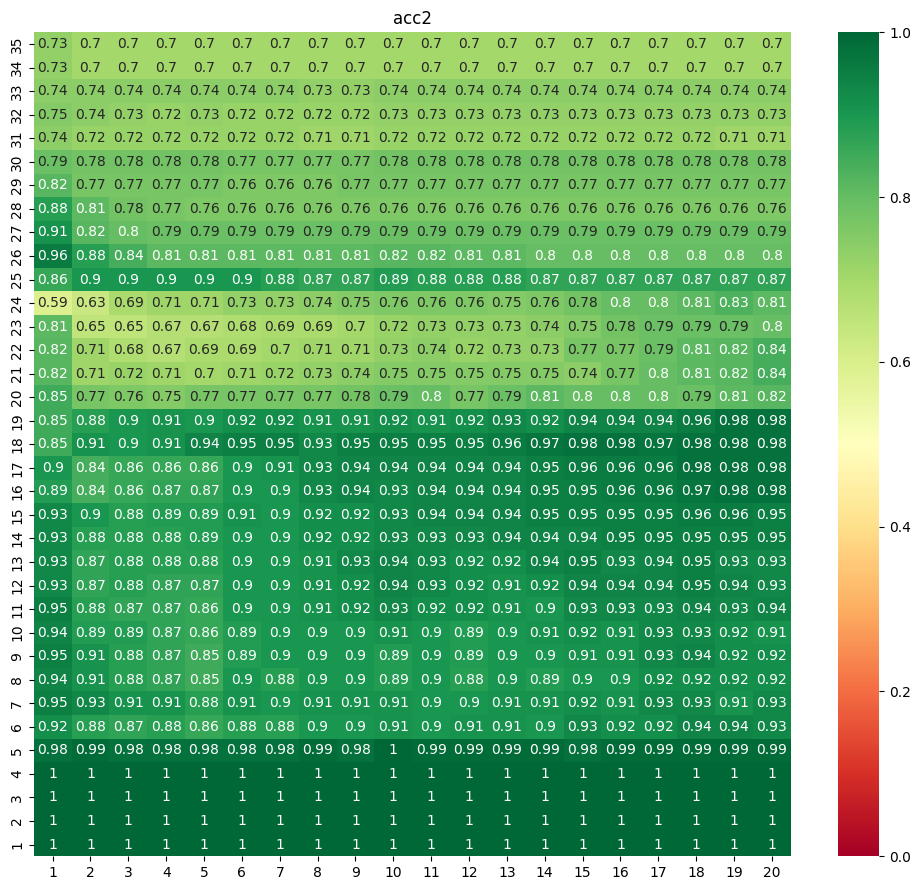

In [4]:
from utils import misc
task_name = 'turning_points'
loaded_data = misc.load_dict_from_json(f"output/turning_points_swap_was_were.json")
misc.plot_score_heatmaps(loaded_data, score_types=['acc2'])

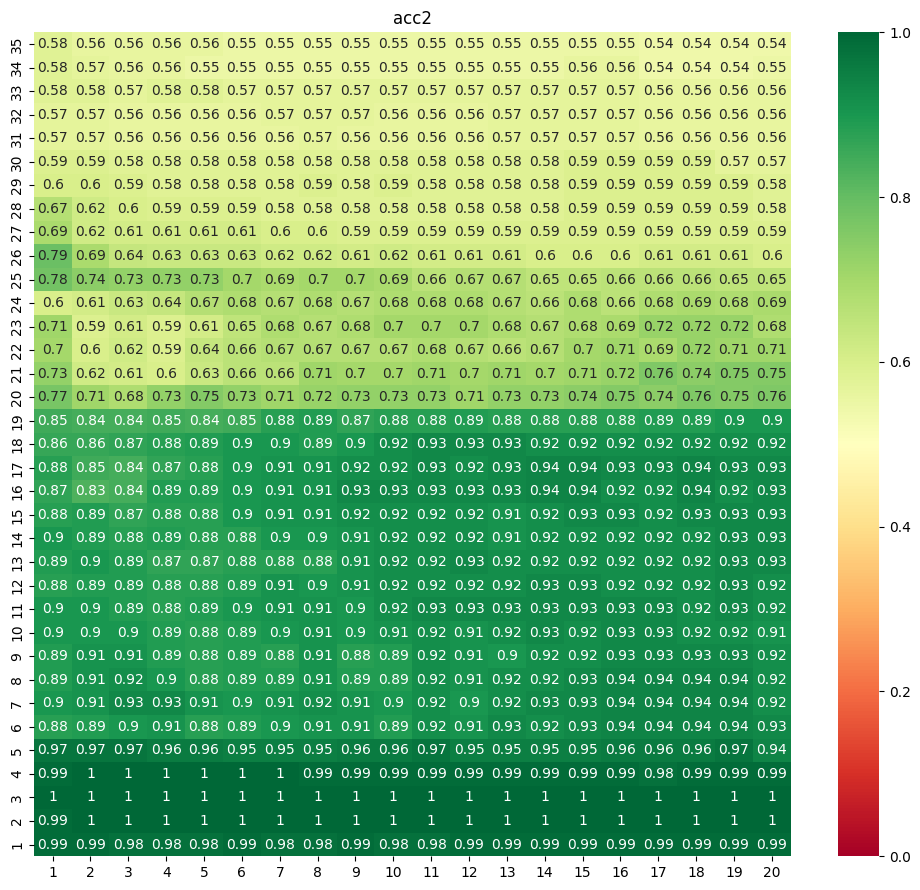

In [3]:
from utils import misc
task_name = 'turning_points'
loaded_data = misc.load_dict_from_json(f"output/turning_points_swap_is_are.json")
misc.plot_score_heatmaps(loaded_data, score_types=['acc2'])

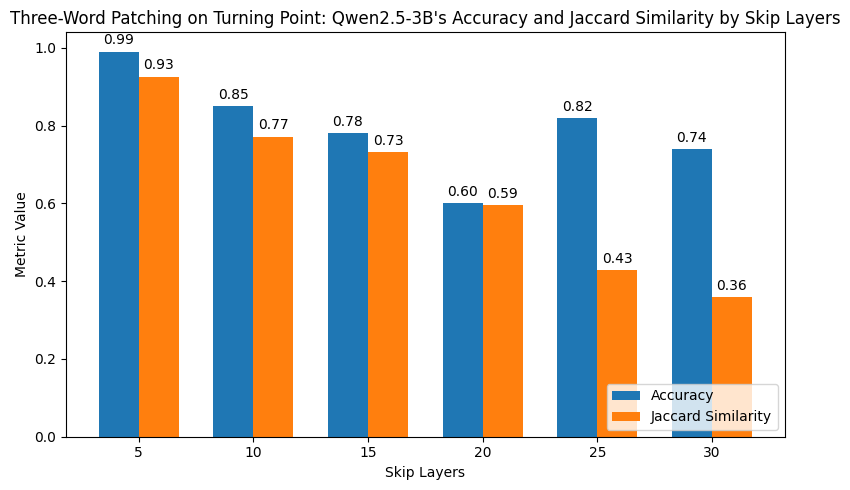

In [ ]:
skip_layers = skip_up_to

plot_skip_layer_metrics(skip_layers, acc, jcc, model_name="Qwen2.5-3B", schema="Three-Word Patching on Turning Point")

# Plot Not the Turning Points

In [8]:
def ngram(n, model, skip_up_to, max_steps, extra_steps, k, edited_phrases):

    print("n-gram: ", n)
    print("Skip layers: ", skip_up_to)

    info_lst = []
    # failed_lst = []

    total_failed_by_prepocess = 0
    # total_failed_as_ulsolvable = 0
    total_solvable_og = 0
    total_unsolvable = 0
    total_matches = []

    num_matched = 0
    # total_steps = 0

    for edited in tqdm(edited_phrases):

        if total_solvable_og == 100:
            break

        if not has_required_spaces(edited, num_context = 10):
            continue

        # preprocess text
        edited = text_preprocess(edited)
        if edited is None:
            total_failed_by_prepocess += 1
            continue

        corrupted_text, pre_isare, correct_tobe = edited
        prompt = f"Please fix grammar of the following text: '{corrupted_text}'. The correct text is: {pre_isare}"

        dict_pred_info = defaultdict(dict)

        steps = 1
        for step_i in range(steps):
            # print(prompt)

            if step_i != 0:
                # Prompt: A B C D is .... A B C D [are]
                prompt_tokens = model.to_tokens(prompt, prepend_bos=False)
            else:
                prompt_tokens = model.to_tokens(prompt)

            # print('og prompt: ', prompt_tokens)

            # As we does not need on the turning point, we can skip the last tokens
            # Prompt: A B C D is .... A B C [D]
            # Get the last token of the prompt as the token to predict
            next_token_ref = prompt_tokens[:, -1]
            prompt_tokens = prompt_tokens[:, :-1]      

            # run on the prompt once with cache to store activations to patch in later
            og_logits, og_cache = model.run_with_cache(prompt_tokens)
            # get the top k tokens
            og_topk_indices = get_top_k(og_logits, k)
            # get the highest prob token
            og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

            # # append the token to the sequence
            # prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)
            # print('generated: ', prompt_tokens)
            # # deocde the token
            # prompt = model.to_string(prompt_tokens)[0]
            # print('OG:', prompt)            

            # check if model can solve the task (now, D should be predicted, aka next_token_ref)
            if torch.equal(og_next_token[0], next_token_ref):
                total_solvable_og += 1
            else:
                total_unsolvable += 1
                continue

            # detect copy scenario
            # Prompt: A B C D is .... A B C [D]
            t_matched_1st, _ = detect_ngram_copy(prompt_tokens, n=n)
            t_matched_2nd, _ = detect_ngram_copy(prompt_tokens[:,:-1], n=n)
            t_matched_3nd, _ = detect_ngram_copy(prompt_tokens[:,:-2], n=n)
            
            if t_matched_1st is not None and t_matched_2nd and t_matched_3nd is not None:
                pos_matched = [t_matched_1st, t_matched_2nd, t_matched_3nd]
                pos_current = [len(prompt_tokens[0])-1, len(prompt_tokens[0])-2, len(prompt_tokens[0])-3]
                
                num_matched += 1

                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    pos_matched: list,
                    pos_current: list
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, pos_current, :] = clean_resid_pre[:, pos_matched, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, pos_matched=pos_matched, pos_current=pos_current)
                # Run the model with the patching hook
                patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                    (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                ])

                # def v_patching_hook(
                #     resid_pre: Float[torch.Tensor, "batch pos head_index d_head"],
                #     hook: HookPoint,
                #     position: int
                # ) -> Float[torch.Tensor, "batch pos head_index d_head"]:
                #     # Each HookPoint has a name attribute giving the name of the hook.
                #     clean_resid_pre = og_cache[hook.name]
                #     resid_pre[:, -1, :, :] = clean_resid_pre[:, position, :, :]
                #     return resid_pre
                
                # for layer in range(skip_up_to):
                #     # Use functools.partial to create a temporary hook function with the position fixed
                #     temp_hook_fn = partial(v_patching_hook, position=t_matched)
                #     # Run the model with the patching hook
                #     patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                #         (utils.get_act_name("v", layer), temp_hook_fn)
                #     ])
                
                pt_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                pt_next_token = torch.tensor([pt_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                # check if model can solve the task
                if torch.equal(next_token_ref, pt_next_token[0]):
                    total_matches.append(1)
                else:
                    total_matches.append(0)

                # # append the token to the sequence
                # pt_prompt_tokens = torch.cat([prompt_tokens, pt_next_token], dim=1)
                # # deocde the token
                # pt_prompt = model.to_string(pt_prompt_tokens)[0]      
                # print('PT:\n')
                # print(pt_prompt)

                dict_pred_info[step_i]['original'] = og_topk_indices
                dict_pred_info[step_i]['copy'] = get_top_k(patched_logits, k)
            else:
                # not enough context for cp
                total_solvable_og -= 1

            # # append the token to the sequence
            # prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)
            # # deocde the token
            # prompt = model.to_string(prompt_tokens)[0]
            # print('OG:\n')
            # print(prompt)
            # print("Avg accuracy: ", total_solvable_pt / total_solvable_og)
            # a

        info_lst.append(dict_pred_info)
        
    jcc, acc = get_acc(info_lst)
    print("Avg jaccard similarity: ", jcc)
    print("Avg accuracy 2: ", acc)
    print("Avg accuracy 3: ", sum(total_matches) / len(total_matches))
    print("#Sample: ", len(total_matches))
    print('#Unsolvable: ', total_unsolvable)
    return jcc, acc, sum(total_matches) / len(total_matches)

In [9]:
seed = 5
extra_steps = 5
max_steps = 1024
k=100
seed_everything(seed)

jcc = []
acc = []

ns = [5]
skip_up_to = [5, 10, 15, 20, 25, 30]
# skip_up_to = [5,6,7,8,9,10]
info_lst = {}
for n in ns:
    info_lst[n] = {}
    for skip in skip_up_to:
        info_lst[n][skip] = {}
        outputs = ngram(n, model, skip, max_steps, extra_steps, k, edited_sents)
        jcc.append(outputs[0])
        acc.append(outputs[1])
        print("-----------------------------------")

n-gram:  5
Skip layers:  5


  0%|          | 0/5000 [00:00<?, ?it/s]

 19%|█▉        | 953/5000 [00:11<00:50, 80.11it/s] 


Avg jaccard similarity:  0.9157206814232863
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
#Sample:  100
#Unsolvable:  2
-----------------------------------
n-gram:  5
Skip layers:  10


 19%|█▉        | 953/5000 [00:11<00:50, 79.87it/s] 


Avg jaccard similarity:  0.7497431581597863
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
#Sample:  100
#Unsolvable:  2
-----------------------------------
n-gram:  5
Skip layers:  15


 19%|█▉        | 953/5000 [00:11<00:50, 79.67it/s] 


Avg jaccard similarity:  0.6844525524165397
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
#Sample:  100
#Unsolvable:  2
-----------------------------------
n-gram:  5
Skip layers:  20


 19%|█▉        | 953/5000 [00:12<00:51, 79.03it/s] 


Avg jaccard similarity:  0.5380332789814387
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
#Sample:  100
#Unsolvable:  2
-----------------------------------
n-gram:  5
Skip layers:  25


 19%|█▉        | 953/5000 [00:12<00:51, 79.20it/s] 


Avg jaccard similarity:  0.3917723367860723
Avg accuracy 2:  0.82
Avg accuracy 3:  0.82
#Sample:  100
#Unsolvable:  2
-----------------------------------
n-gram:  5
Skip layers:  30


 19%|█▉        | 953/5000 [00:12<00:51, 78.55it/s] 

Avg jaccard similarity:  0.336666002352064
Avg accuracy 2:  0.66
Avg accuracy 3:  0.66
#Sample:  100
#Unsolvable:  2
-----------------------------------


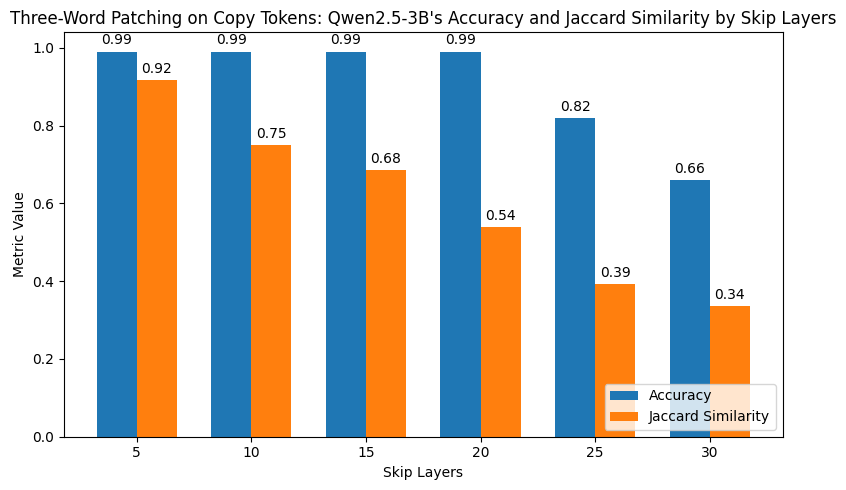

In [10]:
skip_layers = skip_up_to

plot_skip_layer_metrics(skip_layers, acc, jcc, model_name="Qwen2.5-3B", schema="Three-Word Patching on Copy Tokens")

# Plot on Dif Context

In [16]:
from datasets import load_from_disk
from tqdm import tqdm

# Load the dataset from disk
num_samples = 10000
subset = load_from_disk("/home/longnhat/workspace_phu/CopyMech/english_insertions")
prompt_list = []

base_sents = subset['train']['base_sentence'][:num_samples]
phrases = subset['train']['phrase'][:num_samples]
edited_sents = subset['train']['edited_sentence'][:num_samples]

import gc
del subset
gc.collect()

1904

In [13]:
import torch

def find_dif_pos(tensor: torch.Tensor, pos: int) -> int:
    """
    Given a tensor of shape (1, n) and an index pos, returns the index
    of the last occurrence (before the final element) of the tensor's final value,
    ensuring that the found index is different from pos.
    
    Example:
      tensor = [[31, 11, 22, 551, 11, 223, 42, 11]]
      pos = 1
      The final value is 11. The occurrences of 11 (excluding the last element) 
      are at positions 1 and 4. Since pos=1, we choose 4.
      
      Returns: 4
    """
    if pos is None:
        return None
    # Convert tensor to a 1D list (we assume tensor is of shape (1, n))
    row = tensor[0]
    final_val = row[-1].item()
    
    # Scan from the second-to-last element backwards
    for i in range(len(row) - 2, -1, -1):
        if row[i].item() == final_val and i != pos:
            return i
    return None  # or raise an error if not found

# Test example:
tensor = torch.tensor([[31, 11, 22, 551, 11, 223, 42, 11]])
pos = 1
output = find_dif_pos(tensor, pos)
print("Output:", output)  # Expected output: 4


Output: 4


In [11]:
def ngram(n, model, skip_up_to, max_steps, extra_steps, k, edited_phrases):

    print("n-gram: ", n)
    print("Skip layers: ", skip_up_to)

    info_lst = []
    failed_lst = []

    total_failed_by_prepocess = 0
    # total_failed_as_ulsolvable = 0
    total_solvable_og = 0
    total_unsolvable = 0
    total_matches = []

    num_matched = 0
    # total_steps = 0

    for edited in tqdm(edited_phrases):

        if total_solvable_og == 100:
            break

        if not has_required_spaces(edited, num_context = 10):
            continue

        # preprocess text
        edited = text_preprocess(edited)
        if edited is None:
            total_failed_by_prepocess += 1
            continue
        corrupted_text, pre_isare, correct_tobe = edited
        prompt = f"Please fix grammar of the following text: '{corrupted_text}'. The correct text is: {pre_isare}"

        # edited_ids = tokenizer.encode(edited, return_tensors='pt')
        # steps = extra_steps + edited_ids.size(1)
        # if steps > max_steps:
        #     steps = max_steps
        # total_steps += steps
        steps = 1

        dict_pred_info = defaultdict(dict)

        for step_i in range(steps):
            if step_i != 0:
                prompt_tokens = model.to_tokens(prompt, prepend_bos=False)
            else:
                prompt_tokens = model.to_tokens(prompt)

            _t_matched, _ = detect_ngram_copy(prompt_tokens, n=n, skip_up_to=skip_up_to)
            t_matched_1st = find_dif_pos(prompt_tokens, _t_matched)
            _t_matched, _ = detect_ngram_copy(prompt_tokens[:,:-1], n=n, skip_up_to=skip_up_to)
            t_matched_2nd = find_dif_pos(prompt_tokens[:,:-1], _t_matched)
            _t_matched, _ = detect_ngram_copy(prompt_tokens[:,:-2], n=n, skip_up_to=skip_up_to)
            t_matched_3rd = find_dif_pos(prompt_tokens[:,:-2], _t_matched)
            
            # detect copy scenario
            if t_matched_1st is not None and t_matched_2nd is not None and t_matched_3rd is not None:
                pos_matched = [t_matched_1st, t_matched_2nd, t_matched_3rd]
                pos_current = [len(prompt_tokens[0])-1, len(prompt_tokens[0])-2, len(prompt_tokens[0])-3]
                
                # run on the prompt once with cache to store activations to patch in later
                og_logits, og_cache = model.run_with_cache(prompt_tokens)
                # get the top k tokens
                og_topk_indices = get_top_k(og_logits, k)
                # get the highest prob token
                og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                # check if model can solve the task
                decoded_og_next_token = model.to_string(og_next_token)[0]
                if 'are' in decoded_og_next_token and correct_tobe == 'are':
                    total_solvable_og += 1
                elif 'is' in decoded_og_next_token and correct_tobe == 'is':
                    total_solvable_og += 1
                else:
                    total_unsolvable += 1
                    continue
            
                # num_matched += 1

                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    pos_matched: list,
                    pos_current: list
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, pos_current, :] = clean_resid_pre[:, pos_matched, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, pos_matched=pos_matched, pos_current=pos_current)
                # Run the model with the patching hook
                patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                    (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                ])

                # def v_patching_hook(
                #     resid_pre: Float[torch.Tensor, "batch pos head_index d_head"],
                #     hook: HookPoint,
                #     position: int
                # ) -> Float[torch.Tensor, "batch pos head_index d_head"]:
                #     # Each HookPoint has a name attribute giving the name of the hook.
                #     clean_resid_pre = og_cache[hook.name]
                #     resid_pre[:, -1, :, :] = clean_resid_pre[:, position, :, :]
                #     return resid_pre
                
                # for layer in range(skip_up_to):
                #     # Use functools.partial to create a temporary hook function with the position fixed
                #     temp_hook_fn = partial(v_patching_hook, position=t_matched)
                #     # Run the model with the patching hook
                #     patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                #         (utils.get_act_name("v", layer), temp_hook_fn)
                #     ])
                
                pt_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                pt_next_token = torch.tensor([pt_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                if torch.equal(og_next_token, pt_next_token):
                    total_matches.append(1)
                else:
                    total_matches.append(0)

                # # append the token to the sequence
                # pt_prompt_tokens = torch.cat([prompt_tokens, pt_next_token], dim=1)
                # # deocde the token
                # pt_prompt = model.to_string(pt_prompt_tokens)[0]      
                # print('PT:\n')
                # print(pt_prompt)

                dict_pred_info[step_i]['original'] = og_topk_indices
                dict_pred_info[step_i]['copy'] = get_top_k(patched_logits, k)
            else:
                total_solvable_og -= 1

        info_lst.append(dict_pred_info)
        
    jcc, acc = get_acc(info_lst)
    print("Avg jaccard similarity: ", jcc)
    print("Avg accuracy 2: ", acc)
    print("Avg accuracy 3: ", sum(total_matches) / len(total_matches))
    print("#Sample: ", len(total_matches))
    print('#Unsolvable: ', total_unsolvable)
    return jcc, acc, sum(total_matches) / len(total_matches)

In [17]:
seed = 5
extra_steps = 5
max_steps = 1024
k=100
seed_everything(seed)

jcc = []
acc = []

ns = [5]
skip_up_to = [5, 10, 15, 20, 25, 30]
# skip_up_to = [5,6,7,8,9,10]
info_lst = {}
for n in ns:
    info_lst[n] = {}
    for skip in skip_up_to:
        info_lst[n][skip] = {}
        outputs = ngram(n, model, skip, max_steps, extra_steps, k, edited_sents)
        jcc.append(outputs[0])
        acc.append(outputs[1])
        print("-----------------------------------")

n-gram:  5
Skip layers:  5


100%|██████████| 10000/10000 [00:05<00:00, 1852.64it/s]


Avg jaccard similarity:  0.7625872389284549
Avg accuracy 2:  0.8235294117647058
Avg accuracy 3:  0.8235294117647058
#Sample:  17
#Unsolvable:  29
-----------------------------------
n-gram:  5
Skip layers:  10


100%|██████████| 10000/10000 [00:05<00:00, 1871.98it/s]


Avg jaccard similarity:  0.6762974363316185
Avg accuracy 2:  0.5882352941176471
Avg accuracy 3:  0.5882352941176471
#Sample:  17
#Unsolvable:  29
-----------------------------------
n-gram:  5
Skip layers:  15


100%|██████████| 10000/10000 [00:05<00:00, 1870.77it/s]


Avg jaccard similarity:  0.5674957294770681
Avg accuracy 2:  0.47058823529411764
Avg accuracy 3:  0.47058823529411764
#Sample:  17
#Unsolvable:  29
-----------------------------------
n-gram:  5
Skip layers:  20


100%|██████████| 10000/10000 [00:05<00:00, 1833.93it/s]


Avg jaccard similarity:  0.4060673840537828
Avg accuracy 2:  0.35294117647058826
Avg accuracy 3:  0.35294117647058826
#Sample:  17
#Unsolvable:  29
-----------------------------------
n-gram:  5
Skip layers:  25


100%|██████████| 10000/10000 [00:05<00:00, 1864.23it/s]


Avg jaccard similarity:  0.30004632633136946
Avg accuracy 2:  0.17647058823529413
Avg accuracy 3:  0.17647058823529413
#Sample:  17
#Unsolvable:  29
-----------------------------------
n-gram:  5
Skip layers:  30


100%|██████████| 10000/10000 [00:05<00:00, 1853.27it/s]

Avg jaccard similarity:  0.21065321689508873
Avg accuracy 2:  0.0
Avg accuracy 3:  0.0
#Sample:  17
#Unsolvable:  29
-----------------------------------


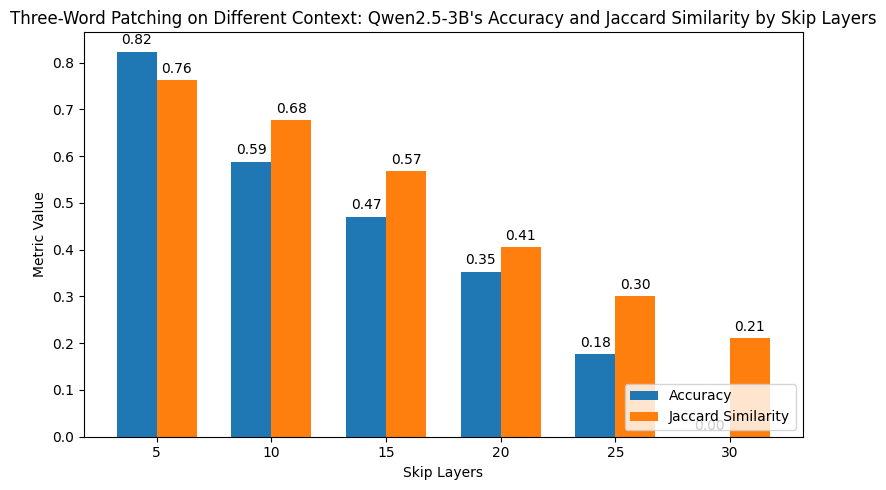

In [19]:
skip_layers = skip_up_to

plot_skip_layer_metrics(skip_layers, acc, jcc, model_name="Qwen2.5-3B", schema="Three-Word Patching on Different Context")